# Реализация отбора предложений (Гареева)

### Функция сложности слова

In [1]:
%run scripts/word_difficulty.py

### Функция создания искажений

In [2]:
%run scripts/create_distortions.py

### Белый список слов

Для того, чтобы определять существуемость слова, будем использовать большой датасет русских слов. (https://github.com/danakt/russian-words)

In [3]:
dirname = 'datasets/white_list'
fullname = os.path.join(dirname, 'russian.txt')

if not os.path.exists(fullname):
    url = 'https://github.com/danakt/russian-words/raw/master/russian.txt'
    r = requests.get(url)
    os.makedirs(dirname, exist_ok=True)
    with open(fullname, 'wb') as ru:
        ru.write(r.content)
    
white_list_df = pd.read_csv(fullname, sep='\n', encoding='cp1251', names=['word'])
white_list_df =  white_list_df[~white_list_df['word'].str.istitle()]
white_list_df = white_list_df.set_index('word')

### Список сложных слов

Реализация функции, которая будет на вход получать список слов, а на выход получать список словарей для каждого сложного слова, отобранного по критериям, со всей нужной информацией: индексом в предложении, самим словом, сложностью и списком искажений.

In [4]:
def get_complex_word_list(sentence_words: List[str]) -> List[dict]:
    complex_words = dict()
    for index, word in enumerate(sentence_words):
        word, is_capitalized = transform_word(word)
        if word in white_list_df.index:
            difficulty = word_difficulty(word)
            if difficulty['difficulty'] < 0.5 or difficulty['lemma'] in complex_words:
                complex_words[difficulty['lemma']] = None
                continue
            distortions = create_distortions(word=word, lemma=difficulty['lemma'] , max_amount=6)
            if len(distortions) == 0:
                continue
            word = {'index': index,
                    'word': word.capitalize() if is_capitalized else word,
                    'difficulty': round(difficulty['difficulty'], 2),
                    'distortions': list(distortion.capitalize() if is_capitalized else distortion \
                                        for distortion in distortions)}
            complex_words[difficulty['lemma']] = word
    return list(word for word in complex_words.values() if word is not None)

Протестируем

In [5]:
complex_words = get_complex_word_list(sentence_words=('Написанные для детей произведения о необыкновенных приключениях земной' +
                                                      'девочки Алисы погружают читателя в мир фантастики и сказок.').split())
complex_words

[{'index': 0,
  'word': 'Написанные',
  'difficulty': 0.52,
  'distortions': ['Напизаные', 'Написаные', 'Напизанные']},
 {'index': 6,
  'word': 'приключениях',
  'difficulty': 0.61,
  'distortions': ['преключениях']},
 {'index': 9,
  'word': 'погружают',
  'difficulty': 0.71,
  'distortions': ['погружяют', 'пагружяют', 'пагружают']}]

### Выбор проверяемых слов

Функция выбора проверяемого слова принимает на вход список сложных слов в предложении и предполагаемый сет уже использованных слов и возвращает индекс выбранного слова в списке, если его вообще можно выбрать.

In [6]:
from typing import Set

def choose_word_id(complex_words: List[dict], used_words: Set[str]=set()) -> Optional[int]:
    for complex_words in sorted(enumerate(complex_words), key=(lambda word: word[1]['difficulty']), reverse=True):
        if complex_words[1]['word'] not in used_words:
            return complex_words[0]
    return None

Протестируем

In [7]:
print(complex_words[choose_word_id(complex_words=complex_words)])
print(complex_words[choose_word_id(complex_words=complex_words, used_words={'необыкновенных', 'приключениях'})])
print(complex_words[choose_word_id(complex_words=complex_words, used_words={'необыкновенных', 'погружают'})])
print(choose_word_id(complex_words=complex_words, used_words={'необыкновенных', 'погружают','приключениях', 'произведения'}))

{'index': 9, 'word': 'погружают', 'difficulty': 0.71, 'distortions': ['погружяют', 'пагружяют', 'пагружают']}
{'index': 9, 'word': 'погружают', 'difficulty': 0.71, 'distortions': ['погружяют', 'пагружяют', 'пагружают']}
{'index': 6, 'word': 'приключениях', 'difficulty': 0.61, 'distortions': ['преключениях']}
0


### Анализ предложения

Функция, делающая полный анализ предложения, принимает на вход само предложение, обрабатывает его и возвращает словарь JSON со всей нужной информацией, который в последствие будет строкой в файле всех предложений. Если предложение не подходит по длине - его не рассматриваем.

In [8]:
def analyze_sentence(sentence: str, used_words: Set[str]=set()) -> Optional[dict]:
    sentence = re.sub('«|»', '', sentence)
    sentence = re.sub('\xa0', ' ', sentence).strip()
    sentence_words = sentence.split()
    if 8 <= len(sentence_words) <= 25:
        complex_words = get_complex_word_list(sentence_words=sentence_words)
        using_word_id = choose_word_id(complex_words, used_words)
        if using_word_id is not None:
            return {
                'sentence': sentence,
                'using_word_id': using_word_id,
                'complex_words': complex_words
            }
    return None

Протестируем

In [9]:
print(analyze_sentence(sentence='Написанные для детей произведения о необыкновенных приключениях земной' +
                            'девочки Алисы погружают читателя в мир фантастики и сказок.',
                      used_words={'приключениях'}))
print(analyze_sentence(sentence='Простые слова.'))

{'sentence': 'Написанные для детей произведения о необыкновенных приключениях земнойдевочки Алисы погружают читателя в мир фантастики и сказок.', 'using_word_id': 2, 'complex_words': [{'index': 0, 'word': 'Написанные', 'difficulty': 0.52, 'distortions': ['Напизаные', 'Написаные', 'Напизанные']}, {'index': 6, 'word': 'приключениях', 'difficulty': 0.61, 'distortions': ['преключениях']}, {'index': 9, 'word': 'погружают', 'difficulty': 0.71, 'distortions': ['погружяют', 'пагружяют', 'пагружают']}]}
None


### Хранение предложений

Напишем примеры классов с реализацией сохранения и чтения информации о предложениях в выбранном формате.

In [10]:
import json
from itertools import islice

class JSONLCreator:
    fullname = ''
    number_of_sentences = 0
    
    def __init__(self, dirname: str='jsonl', filename: str='output.jsonl'):
        self.fullname = os.path.join(dirname, filename)
        os.makedirs(dirname, exist_ok=True)
        open(self.fullname, 'w').close()
        
    def _add_content(self, content: Optional[dict]) -> None:
        with open(self.fullname, 'a') as outfile:
            json.dump(content, outfile, ensure_ascii=False)
            outfile.write('\n')

    def add_sentence_info(self, sentence: Optional[dict]) -> None:
        self._add_content(content=sentence)
        self.number_of_sentences += 1
            
    def end_file(self): 
        meta_info = {'number_of_sentences': self.number_of_sentences}
        self._add_content(content=meta_info)
        
        
class JSONLReader:
    fullname = ''
    number_of_sentences = 0
    
    def __init__(self, dirname: str='jsonl', filename: str='output.jsonl'):
        self.fullname = os.path.join(dirname, filename)
        meta_info = json.loads(self._get_last_line())
        self.number_of_sentences = meta_info['number_of_sentences']
                                     
    def _get_last_line(self) -> str:                             
        with open(self.fullname, 'rb') as file:
            try:
                file.seek(-2, os.SEEK_END)
                while file.read(1) != b'\n':
                    file.seek(-2, os.SEEK_CUR)
            except OSError:
                
                file.seek(0)
            last_line = file.readline().decode()
        return last_line
    
    def get_n_sentence_info(self, n) -> dict:
        if not (0 <= n < self.number_of_sentences):
            return None
        with open(self.fullname, 'r') as file:
            sentence_info = json.loads(next(islice(file, n, None)))
        return sentence_info

Протестируем

In [11]:
sentences = ['Написанные для детей произведения о необыкновенных приключениях земной' +
                            'девочки Алисы погружают читателя в мир фантастики и сказок.',
            'Тогда я позвонил в Минералогический музей Фридману, с которым я когда-то встречался на Памире.']

jsonl_creator = JSONLCreator(filename='test.jsonl')
for sentence in sentences:
    jsonl_creator.add_sentence_info(analyze_sentence(sentence))
jsonl_creator.end_file()

jsonl_reader = JSONLReader(filename='test.jsonl')
print(jsonl_reader.number_of_sentences)
print(jsonl_reader.get_n_sentence_info(n=0))
print(jsonl_reader.get_n_sentence_info(n=1))
print(jsonl_reader.get_n_sentence_info(n=-1))
print(jsonl_reader.get_n_sentence_info(n=2))

2
{'sentence': 'Написанные для детей произведения о необыкновенных приключениях земнойдевочки Алисы погружают читателя в мир фантастики и сказок.', 'using_word_id': 2, 'complex_words': [{'index': 0, 'word': 'Написанные', 'difficulty': 0.52, 'distortions': ['Напизаные', 'Написаные', 'Напизанные']}, {'index': 6, 'word': 'приключениях', 'difficulty': 0.61, 'distortions': ['преключениях']}, {'index': 9, 'word': 'погружают', 'difficulty': 0.71, 'distortions': ['погружяют', 'пагружяют', 'пагружают']}]}
None
None
None


### Корпус текстов

Для нашего бота с говорящим названием "Граммазека": грамматика и Громозека - имя персонажа из серии книг об Алисе Селезнёвой Кира Булычёва, будем использовать корпус текста из вышеупомянутых книг.

Скачаем и преобразуем нужный текст.

In [12]:
def save_alisa_selezneva_txt(dirname: str, new_filename: str) -> None:
    fullname = os.path.join(dirname, new_filename)
    
    if not os.path.exists(fullname):
        with open(os.path.join(dirname, 'alisa-selezneva-kompilyaciya-knigi-1-21.txt'), 'rb') as f:
            text = f.read().decode('Windows-1251')
            with open(fullname, 'wb') as ru:
                ru.write(text.encode('utf-8'))
    return fullname

alisa_selezneva_fullname = save_alisa_selezneva_txt(dirname='datasets/texts/alisa_selezneva', 
                                                    new_filename='alisa_selezneva.txt')

### Отбор предложений

Проанализируем корпус текстов и сохраним подходящие предложения и информацию о них в обговоренным формате.

In [13]:
def get_output_jsonl(filepath: str) -> str:
    return '.'.join(os.path.basename(filepath).split('.')[:-1]) + '.jsonl'

def save_sentences(filepath: str, output_jsonl: str=None, stop=None) -> str:
    output_jsonl = output_jsonl if output_jsonl else get_output_jsonl(filepath)
    jsonl_creator = JSONLCreator(filename=output_jsonl)
    used_words = set()
    with open(filepath, 'rb') as f:
        for i, sentence in enumerate(tqdm(re.findall(r'.*?[.!\?]', f.read().decode('utf-8')))):
            sentence_info = analyze_sentence(sentence, used_words)
            if sentence_info is None:
                continue
            used_words.add(sentence_info['complex_words'][sentence_info['using_word_id']]['word'])
            jsonl_creator.add_sentence_info(sentence_info)
            if stop and stop <= i:
                break
    jsonl_creator.end_file()
    return output_jsonl

In [14]:
# example_jsonl = save_sentences(filepath=alisa_selezneva_fullname, output_jsonl='example.jsonl', stop=50)
example_jsonl = 'example.jsonl'
jsonl_reader = JSONLReader(filename=example_jsonl)
jsonl_reader.number_of_sentences

6

In [15]:
# alisa_selezneva_jsonl = save_sentences(filepath=alisa_selezneva_fullname)
alisa_selezneva_jsonl = get_output_jsonl(filepath=alisa_selezneva_fullname)

### Анализ результатов

Посмотрим, что вышло в результате.

In [16]:
def get_sentence_info_df(filename: str) -> pd.DataFrame:
    jsonl_reader = JSONLReader(filename=filename)
    print('number_of_sentences:', jsonl_reader.number_of_sentences)
    text_df = pd.DataFrame(columns=list(['sentence', 'using_word', 'word_difficulty', 'distortions', 'distortions_amount']))
    for n in tqdm(range(jsonl_reader.number_of_sentences)):
        sentence_info = jsonl_reader.get_n_sentence_info(n)
        using_word = sentence_info['complex_words'][sentence_info['using_word_id']]
        row = {'sentence': sentence_info['sentence'],
               'using_word': using_word['word'],
               'word_difficulty':  using_word['difficulty'],
               'distortions': using_word['distortions'],
               'distortions_amount': len(using_word['distortions'])}
        text_df = text_df.append(row, ignore_index=True)
    return text_df

In [17]:
alisa_selezneva_df = get_sentence_info_df(alisa_selezneva_jsonl)
alisa_selezneva_df

  0%|                                                                                        | 0/13978 [00:00<?, ?it/s]

number_of_sentences: 13978


100%|████████████████████████████████████████████████████████████████████████████| 13978/13978 [04:52<00:00, 47.85it/s]


,sentence,using_word,word_difficulty,distortions,distortions_amount
0,Написанные для детей произведения о необыкнове...,погружают,0.71,"[пагружяют, погружяют, пагружают]",3
1,"Шуша сказал, что пойдет в школу вместе с Алисо...",учительница,0.65,[учитильница],1
2,"По-моему, когда я уходил в первый раз в школу,...",По-моему,0.59,"[Помоему, По моему]",2
3,"Ей полезно будет знать, с каким несерьезным че...",несерьезным,0.85,[несерьездным],1
4,"Может быть, эти записки помогут учительнице во...",учительнице,0.65,"[учытильнице, учитильнице, учытельнице]",3
...,...,...,...,...,...
13973,"— Ты сердишься, — сказал Чжан Цзолинь, — значи...",сердишься,0.57,[сирдишься],1
13974,Лишь шум крыльев в коридоре напомнил о беглеце.,беглеце,0.57,[биглеце],1
13975,"Мы поддались обманщику, а он со своими друзьям...",поддались,0.64,"[подализь, поддализь, подались]",3
13976,"А друиды острова Элис — вовсе не друидами, а п...",тамошними,0.61,[тамашними],1


In [18]:
alisa_selezneva_df.sort_values(by=['word_difficulty', 'using_word']).tail(20)

,sentence,using_word,word_difficulty,distortions,distortions_amount
9533,Потребовались вся моя деликатность и дипломати...,дипломатичность,1.0,"[дипламатичность, дипламатичнасть, дипломатичн...",3
1453,Полосков вынул из кармана портативный металлои...,металлоискатель,1.0,"[металоискатель, металлоизкатель, металоизкатель]",3
1425,"— Странно, но кто-то разбил в нем индикатор ме...",металлоискателя,1.0,"[металлоизкателя, металоискателя, металоизкателя]",3
137,Девушки из оранжереи Красная роза украсили его...,музыкально-литературный,1.0,"[музыкальнолитературный, музыкально литературный]",2
13370,"— Ты же знаешь, так неблагоприятно расположили...",неблагоприятно,1.0,[неблагопреятно],1
3007,"— Здесь мастеров нет, разница между Ларисой и ...",непринципиальная,1.0,"[неприлнципиальная, непрелнципиальная, непренц...",5
705,"Из воды, метрах в двадцати от берега, черным у...",полузатопленной,1.0,[полузатопленой],1
747,На обратном пути заехали на полузатопленную ба...,полузатопленную,1.0,[полузатопленую],1
10235,"Флаер опустился у полуразрушенной крепости, на...",полуразрушенной,1.0,"[полурасрушеной, полуразрушеной, полурасрушенной]",3
3453,"Там, посередине, на небольшом холмике, стоял п...",полуразрушенный,1.0,"[полуразрушеный, полурасрушенный, полурасрушеный]",3


Всего отобралось 13978 предложений с таким распределением сложности выбранного слова:

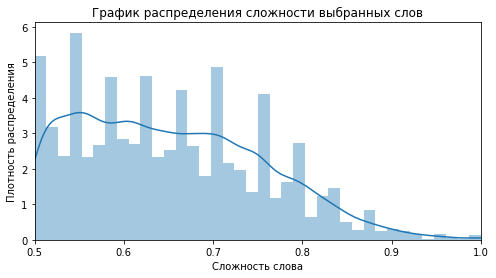

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.distplot(x=alisa_selezneva_df['word_difficulty'], label='1')

ax.set_title('График распределения сложности выбранных слов')
ax.set_ylabel('Плотность распределения')
ax.set_xlabel('Сложность слова')

plt.xlim(0.5, 1)
plt.show()

Всего слов: 13978
Слов без искажений: 0
Слов с искажениями: 13978


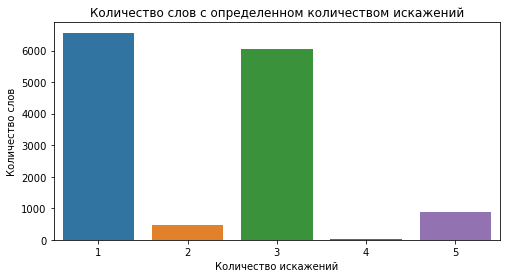

In [20]:
countplot_distortions_df(alisa_selezneva_df)